# HCM Project: ML on EHR Data

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

# Common imports
import numpy as np
import os
import xlrd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import data 
import pandas as pd 
o_data = pd.read_excel('/home/beepul/HCM-Project/HCM_Methods_Data/OrganizedData/EHR_Data/HCM_Table_NO_Outcomes.xls')

In [3]:
o_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Columns: 115 entries, MRN to MI
dtypes: datetime64[ns](1), float64(45), int64(1), object(68)
memory usage: 735.9+ KB


In [4]:
pd.set_option('display.max_columns',120)
o_data
o_data.shape

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,LGE,Ranolazine,ApicalHCM,CKD,DOB,MRI_parameter,Echo_parameter,TET_parameter,H_NSVT_N,H_VTVF,H_VTVF_N,H_ICDShock_N,H_ATP,Outcome_during_FU,NSVT_N,VTVF,VTVF_N,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI
0,JH15025246,JH15025246,2,Abdelrahman,T,10659.0,Abdelrahman,Elwalid,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,2.0,2,NaN,NaN,1.0,0,0,0.0,0.0,0.0,0,0.0,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0.0,,,,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19,67,79,26,5.1,1.27,0.974,1.4,266,27,20,50,3.2,1.2,2.666667,1,-7.4825,-0.66625,0.503125,550.0,10.5,68,146,81,162.0,204,85,89.5,130,1,,NaN,NaN,1973-02-08,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,,NaN,,NaN,NaN,NaN,,,,,
1,JH90696195,JH90696195,3,Abron,C,10001.0,Abron,Timothy,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2,2.0,0,NaN,NaN,1.0,1,1,0.0,1.0,0.0,1,0.0,0,0,0,1,1,0,1,1,2,3,1,1,0,0,0.0,1,0,0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56,71,31,4.5,0.48,0.81,0.62,371,14,10,16,1.7,1.5,1.100000,1.9,-16.978333,-0.966111,0.982222,192.0,2.3,95,138,80,120.0,63,37,83,90,1,,NaN,NaN,1938-02-12,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,0,0.0,1,0.0,0.0,0.0,0,0,0,0,0
2,JH86623981,JH86623981,4,Adams,I,20052.0,Adams,David,0.0,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,1.0,0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,0,0.0,1,0,0,0,0,0,0,1,1,1,1,0,,0,NaN,,,,NaN,NaN,1.727,76.204,25.550129,54.000000,NaN,NaN,NaN,NaN,,,,,3.3,0.298,0.447,0.67,172,7,4,12,1.3,0.9,1.444444,,,,,730.0,13.7,75,87,58,155.0,94,52,95,144,,0,NaN,0.0,1962-08-16,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,,NaN,NaN,NaN,,,,,
3,JH14339131,JH14339131,5,Adipudi,C,10201.0,Adipudi,Ramesh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1.0,0,NaN,NaN,0.0,1,1,0.0,0.0,0.0,1,0.0,0,1,0,0,0,0,2,1,1,0,0,0,0,0,0.0,0,0,0,1.0,0.0,1.7018,70.37,24.297999,41.215606,1,NaN,NaN,NaN,,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19,68,146,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74,114,66,166.0,149,77,93,129,0,,NaN,NaN,1967-05-28,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0,0,0
4,JH94072597,JH94072597,6,Adkins,T,10002.0,Adkins,Charles,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,2,NaN,NaN,1.0,1,1,0.0,0.0,0.0,1,0.0,0,1,1,1,0,0,2,1,1,4,0,0,0,0,0.0,0,0,0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,,67.76,125.78,40.55,5.1,0.73,0.946475,0.770356,171.83,15,24,41,1.8,1.4,1.285714,1.174048,-16.47,-1.141111,1.080556,398.0,7.8,65,133,58,141.0,162,48,88.7,130,0,,NaN,NaN,1947-05-02,NaN,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN,0.0,1,1.0,1,0.0,0.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,JH95011356,JH95011356,816,Zaccaria,G,10654.0,Zaccaria,Jeffrey,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0,0,NaN,NaN,0.0,0,0,0.0,0.0,0.0,0,0.0,0,1,0,0,0,0,1,1,1,1,1,0,0,0,0.0,,,,NaN,NaN,1.7272,

(819, 115)

In [5]:
# Make all the features numerical not object types
for i in range(8,115):
    o_data.iloc[:,i] = pd.to_numeric(o_data.iloc[:,i],errors='coerce')

In [6]:
# Make a copy of the data
data = o_data.copy()

In [7]:
# We want to determine all patients whose hearts are capable of an arrythmia
# So an outcome would be if they have ever had VT/VF
# Dropping all patients who dont have all of these outcomes
data = data.dropna(subset=['H_VTVF','VTVF','NSVT','H_NSVT'], how='all')

In [8]:
outcomes = data[['VTVF','H_VTVF','NSVT','H_NSVT']].any(axis=1)
outcomes.value_counts()

False    552
True     161
dtype: int64

In [9]:
# Left with 707 patients who have an outcome
data.shape

(713, 115)

In [10]:
# Need to create an outcomes label vector
# Number of patients who have had an adverse cardiac outcome related ventricular activity
# look into NYHA/HF combination possibly
outcomes = data[['H_VTVF','VTVF','NSVT','H_NSVT']].any(axis=1)
outcomes.value_counts()

False    552
True     161
dtype: int64

In [11]:
# Label Vector
data['Adverse_Outcome'] = outcomes.astype(int)

In [12]:
data.head()

,MRN,MRN_MRI,MRI_ID,Last_Name_MRI,First_Name_Initial_MRI,Record_ID,LastName,FirstName,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,LGE,Ranolazine,ApicalHCM,CKD,DOB,MRI_parameter,Echo_parameter,TET_parameter,H_NSVT_N,H_VTVF,H_VTVF_N,H_ICDShock_N,H_ATP,Outcome_during_FU,NSVT_N,VTVF,VTVF_N,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI,Adverse_Outcome
0,JH15025246,JH15025246,2,Abdelrahman,T,10659.0,Abdelrahman,Elwalid,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19.0,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.0,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,1.0,NaN,NaN,NaN,97977600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,JH90696195,JH90696195,3,Abron,C,10001.0,Abron,Timothy,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.0,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,1.0,NaN,NaN,NaN,-1006214400000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,JH14339131,JH14339131,5,Adipudi,C,10201.0,Adipudi,Ramesh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,NaN,NaN,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.0,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,0.0,NaN,NaN,NaN,-81993600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,JH94072597,JH94072597,6,Adkins,T,10002.0,Adkins,Charles,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,NaN,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.0,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,0.0,NaN,NaN,NaN,-715392000000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,JH63926262,JH63926262,7,AGUILAR,R,10003.0,AGUILAR,ISABEL,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,25.68,12.0,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,333417600000000000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0

In [13]:
# Write Table
data.to_excel("HCM_EHR_with_VTVF_NSVT_Outcomes.xlsx") 

In [164]:
# Removing identifying variables (Names, IDs, etc)
data = data.drop(data.loc[:, 'MRN':'FirstName'].columns, axis = 1)
# Removing DOB
data = data.drop('DOB', axis = 1)

In [165]:
data.head()

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,Protocol,Reasonfortermination,ABPR,FHx_SCD,IVS_3,H_Afib,H_NSVT,SVT,NSVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,LGE,Ranolazine,ApicalHCM,CKD,MRI_parameter,Echo_parameter,TET_parameter,H_NSVT_N,H_VTVF,H_VTVF_N,H_ICDShock_N,H_ATP,Outcome_during_FU,NSVT_N,VTVF,VTVF_N,ICDimplantation,ICDshock,ICDshock_Number,AntiTachycardiaPacing,HF,Transplantation,Death,Stroke,MI,Adverse_Outcome
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19.0,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.0,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.0,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,NaN,NaN,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.0,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,NaN,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.0,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,25.68,12.0,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [166]:
# Removing counts of Variables (_N)
data = data.drop(['H_NSVT_N','H_VTVF_N','NSVT_N','VTVF_N'], axis=1)

In [167]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['H_VTVF','VTVF','H_ATP','H_ICDShock_N','H_NSVT','NSVT'], axis = 1)

In [168]:
# Removing ICD Related Features
data = data.drop(data.loc[:, 'ICDshock':'HF'].columns, axis = 1)

In [169]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['Death'], axis = 1)

In [170]:
# Removing LGE
data = data.drop(['LGE'], axis = 1)

In [171]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['Transplantation','Stroke'], axis = 1)

In [172]:
# Removing Adverse Outcomes related to Ventricular Activity
data = data.drop(['Protocol','Reasonfortermination'], axis = 1)

In [176]:
data.head()
data.shape

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,Metformin,Insulin,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,ABPR,FHx_SCD,IVS_3,H_Afib,SVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,Scar_tissue_volumem_L,LGE_%,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,Ranolazine,ApicalHCM,CKD,MRI_parameter,Echo_parameter,TET_parameter,Outcome_during_FU,ICDimplantation,MI,Adverse_Outcome
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,55.38,19.0,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.0,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,NaN,19.3,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.0,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,NaN,NaN,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.0,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,NaN,NaN,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.0,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,25.68,12.0,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0


(713, 87)

In [215]:
# Calculate Percentage of Missing Values of each feature
features = data.columns[:86]
missing_prop = []
for feature in features[0:]:
    missing = data[feature].isna().sum()
    missing_prop.append(missing/data.shape[0])
missing_prop = np.asarray(missing_prop)

In [234]:
missing_f = features[missing_prop >0.5]

In [235]:
# Removing Empty or Nearly Empty Columns
data = data.drop(missing_f, axis = 1)

In [237]:
# Remove LGE % because Scar Tissue mass/ total mass gives this value
data = data.drop('LGE_%', axis = 1)

In [238]:
data
data.shape

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,ABPR,FHx_SCD,IVS_3,H_Afib,SVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI,Adverse_Outcome
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,1.8288,98.064,29.320892,39.211499,NaN,300.01,58.15,67.000000,79.000000,26.000000,5.1,1.270000,0.974000,1.400000,266.00000,27.00,20.0,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.0,10.5,68.0,146.0,81.0,162.0,204.0,85.0,89.5,130.0,NaN,NaN,0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.7526,107.598,35.029875,71.118412,0.9,160.46,30.96,56.000000,71.000000,31.000000,4.5,0.480000,0.810000,0.620000,371.00000,14.00,10.0,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.0,2.3,95.0,138.0,80.0,120.0,63.0,37.0,83.0,90.0,1.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.7018,70.370,24.297999,41.215606,1.0,NaN,NaN,59.070818,121.630000,49.780000,4.4,1.136415,0.726567,1.564087,158.52439,19.00,68.0,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.0,12.3,74.0,114.0,66.0,166.0,149.0,77.0,93.0,129.0,0.0,0.0,0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.8034,91.254,28.058715,61.363450,0.7,NaN,NaN,67.760000,125.780000,40.550000,5.1,0.730000,0.946475,0.770356,171.83000,15.00,24.0,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.0,7.8,65.0,133.0,58.0,141.0,162.0,48.0,88.7,130.0,1.0,0.0,1
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.7018,52.210,18.027548,25.073238,0.5,222.63,26.96,53.000000,59.630000,28.190000,4.9,1.140000,0.770000,2.500000,140.00000,NaN,NaN,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.7272,83.990,28.154144,37.420945,NaN,280.86,75.94,62.000000,97.000000,36.000000,4.0,0.868000,0.604000,1.400000,211.00000,12.00,18.0,113.0,2.8,1.1,2.545455,1.000000,-14.935000,-0.795000,1.164286,602.0,11.7,51.0,134.0,87.0,153.0,130.0,63.0,83.6,133.0,NaN,NaN,0
815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.8288,90.800,27.148974,21.993155,NaN,169.82,0.00,65.000000,117.000000,41.000000,3.9,0.880000,0.380000,2.300000,246.00000,13.00,6.0,43.0,2.2,1.2,1.830000,0.800000,-18.132778,-1.206667,1.765000,752.0,14.3,58.0,162.0,77.0,166.0,115.0,68.0,83.4,134.0,NaN,NaN,0
816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.6000,75.300,29.414062,61.503080,NaN,NaN,NaN,70.7

(713, 76)

## Statistical Analysis of Features

In [240]:
# Copy Data for statistical analysis
data_final = data.copy()
Outcome = data_final['Adverse_Outcome']
data_final = data_final.drop('Adverse_Outcome',axis = 1)

In [242]:
# Impute Missing data

# Imputing using Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter = 300)
imputed_data = pd.DataFrame(imputer.fit_transform(data_final),columns = data_final.columns)

In [243]:
imputed_data.head()

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,ABPR,FHx_SCD,IVS_3,H_Afib,SVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.195498,0.091536,1.557319,0.042864,1.8288,98.064,29.320892,39.211499,0.746265,300.010000,58.150000,67.000000,79.00,26.00,5.1,1.270000,0.974000,1.400000,266.00000,27.000000,20.000000,50.0,3.2,1.2,2.666667,1.000000,-7.482500,-0.666250,0.503125,550.000000,10.500000,68.000000,146.000000,81.000000,162.000000,204.000000,85.000000,89.500000,130.000000,0.406428,0.003713
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.0,0.0,0.0,1.000000,0.000000,2.000000,0.000000,1.7526,107.598,35.029875,71.118412,0.900000,160.460000,30.960000,56.000000,71.00,31.00,4.5,0.480000,0.810000,0.620000,371.00000,14.000000,10.000000,16.0,1.7,1.5,1.100000,1.900000,-16.978333,-0.966111,0.982222,192.000000,2.300000,95.000000,138.000000,80.000000,120.000000,63.000000,37.000000,83.000000,90.000000,1.000000,0.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,1.7018,70.370,24.297999,41.215606,1.000000,195.363020,28.157971,59.070818,121.63,49.78,4.4,1.136415,0.726567,1.564087,158.52439,19.000000,68.000000,146.0,2.6,1.1,2.363636,0.793761,-13.729608,-1.317255,1.382353,620.000000,12.300000,74.000000,114.000000,66.000000,166.000000,149.000000,77.000000,93.000000,129.000000,0.000000,0.000000
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,1.8034,91.254,28.058715,61.363450,0.700000,168.246579,28.852280,67.760000,125.78,40.55,5.1,0.730000,0.946475,0.770356,171.83000,15.000000,24.000000,41.0,1.8,1.4,1.285714,1.174048,-16.470000,-1.141111,1.080556,398.000000,7.800000,65.000000,133.000000,58.000000,141.000000,162.000000,48.000000,88.700000,130.000000,1.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.358821,1.0,0.0,0.0,1.000000,0.000000,2.000000,0.000000,1.7018,52.210,18.027548,25.073238,0.500000,222.630000,26.960000,53.000000,59.63,28.19,4.9,1.140000,0.770000,2.500000,140.00000,23.541666,59.479232,135.0,1.7,1.0,1.700000,1.100000,-12.721667,-1.022778,1.235556,773.609754,13.888655,71.293963,122.673027,72.148482,172.737076,146.694897,75.735914,90.949304,131.536242,1.000000,0.000000


In [244]:
label1 = imputed_data[(Outcome ==1).values]
label0 = imputed_data[(Outcome ==0).values]

In [245]:
# Separating numerical/continuous from data set
num_full = imputed_data.loc[:,'height_m':'HR_recovery_60s']

In [246]:
# Conduct rank sum test for each feature and record p-value
from scipy import stats
features = num_full.columns
features = np.asarray(features)
total = features.shape[0]
pvalue = np.zeros((1,total))
for i, feature in enumerate(features):
    results = stats.ranksums(label1[feature].values,label0[feature].values)
    pvalue[0,i] = results.pvalue

In [247]:
features[pvalue[0] < 0.05]

array(['BMI', 'Total_myocardial_mass_g', 'Scar_tissue_mass_g', 'LVEDV',
       'LVESV', 'MV_E', 'LVOT_Rest', 'LVOT_Stress', 'IVS_max', 'IVS_PW',
       'Global_S_G', 'Global_SR_S', 'Global_SR_E'], dtype=object)

In [248]:
# FDR Correction

# Rank p values from lowest to highest
sorted_pvalues = np.sort(pvalue)
sorted_pval_ind = np.argsort(pvalue)
ranks = stats.rankdata(sorted_pvalues, method='ordinal')

# Choose false discovery rate: Q = 0.01
Q = 0.01;
BH_crit = np.zeros((1,total))
for i in range(0,total):
    BH_crit[0,i] = (ranks[i]/total)*Q

# Find largest p value among the sorted p-values that is less than its corresponding BH_crit
logical = sorted_pvalues < BH_crit
indices = np.where(logical == 1)[1]
max_index = np.max(indices) + 1

# Sort the features just like the p values were sorted
sorted_features = features[sorted_pval_ind]
sig_features = sorted_features[0,:max_index]

In [249]:
sig_features

array(['IVS_max', 'Global_S_G', 'LVOT_Stress', 'Scar_tissue_mass_g',
       'Global_SR_E', 'IVS_PW', 'Global_SR_S'], dtype=object)

(array([143.,  13.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.   ,  52.867, 105.734, 158.601, 211.468, 264.335, 317.202,
        370.069, 422.936, 475.803, 528.67 ]),
 <BarContainer object of 10 artists>)

(array([130., 295.,  88.,  23.,  10.,   3.,   1.,   1.,   0.,   1.]),
 array([-12.90356957,   8.23278739,  29.36914435,  50.5055013 ,
         71.64185826,  92.77821522, 113.91457217, 135.05092913,
        156.18728609, 177.32364304, 198.46      ]),
 <BarContainer object of 10 artists>)

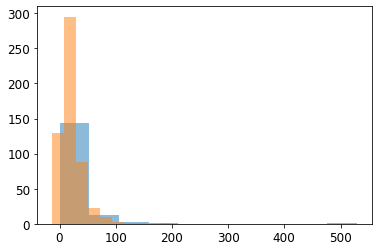

In [250]:
plt.hist(label1['Scar_tissue_mass_g'].values,alpha = 0.5)
plt.hist(label0['Scar_tissue_mass_g'].values,alpha = 0.5)

# Separate Training and Test Data

In [251]:
# Creating training and test set
# This function from sklearn splits the data the same way everytime
# Stratified sampling based on the outcome
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data,test_size=0.2,random_state=42, stratify = data['Adverse_Outcome'])

<AxesSubplot:>

3.4186046511627906

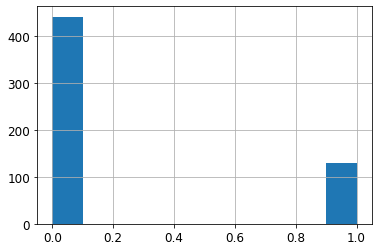

In [252]:
# Checking proportion of positive and negative outcomes in both training and test set
train_set['Adverse_Outcome'].hist()
Proportion = train_set['Adverse_Outcome'].value_counts()[0]/train_set['Adverse_Outcome'].value_counts()[1]
Proportion

<AxesSubplot:>

3.46875

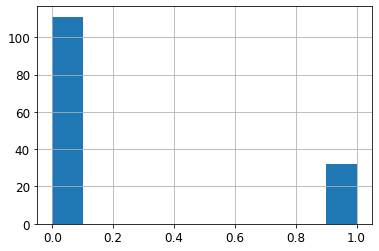

In [253]:
test_set['Adverse_Outcome'].hist()
Proportion = test_set['Adverse_Outcome'].value_counts()[0]/test_set['Adverse_Outcome'].value_counts()[1]
Proportion

In [254]:
# Creating a copy of the training set to work with
training = train_set.copy()
training

,excl_myect,Myectomy,ASA,GENDER,ANGINA,DYSPNEAatexertion,DIZZINESS,PRESYNCOPE,SYNCOPE,H_DM,HCMtype,Race,NYHA,Smoking,H_HTN,H_DL,Statin,H_stroke,H_CAD,H_MI,Antiplt,ICDbase,FHx_HCM,Bbloq,Cabloq,ACEi_ARB,Diuretic,Disopyramide,SAM,MR,ABPR,FHx_SCD,IVS_3,H_Afib,SVT,NewAFib,NYHA2,EPS_VT,height_m,weight_kg,BMI,AGE,Cr,Total_myocardial_mass_g,Scar_tissue_mass_g,EF,LVEDV,LVESV,LA,MV_E,MV_A,EA,MV_DecT,EE,LVOT_Rest,LVOT_Stress,IVS_max,PW,IVS_PW,Apex,Global_S_G,Global_SR_S,Global_SR_E,ExerTime,METS,HR_rest,SBP_rest,DBP_rest,HR_stress,SBP_stress,DBP_stress,Percentage_of_MaxHr,HR_recovery_60s,ICDimplantation,MI,Adverse_Outcome
53,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,1.6510,56.246,20.634668,71.000000,0.72,NaN,NaN,NaN,NaN,NaN,3.0,0.788,1.110000,0.710000,240.00,19.900000,8.000000,103.0,1.600000,0.920000,1.739130,NaN,NaN,NaN,NaN,405.0,8.5,76.0,182.0,101.0,127.0,209.0,109.0,85.2,104.0,NaN,NaN,0
152,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.5748,99.880,40.274274,48.944559,0.50,NaN,NaN,65.000000,NaN,NaN,3.3,1.010,0.890000,1.140000,273.00,14.000000,20.000000,155.0,1.900000,1.800000,1.000000,1.100000,NaN,NaN,NaN,752.0,4.2,91.0,126.0,78.0,131.0,190.0,70.0,77.0,101.0,0.0,0.0,1
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.6764,86.714,30.855594,64.884326,NaN,132.70,32.61,62.688478,69.21,25.82,5.5,1.410,NaN,NaN,170.00,22.000000,7.843111,40.0,2.009217,1.286589,1.561662,0.500000,-13.591765,-1.509412,1.551176,292.0,3.1,111.0,158.0,89.0,153.0,128.0,91.0,102.0,121.0,1.0,0.0,1
282,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.6260,94.802,35.857204,50.343600,1.00,102.62,6.51,71.000000,63.00,18.00,4.3,0.990,0.980000,1.010000,355.00,15.570000,13.000000,77.0,2.100000,1.000000,2.100000,1.400000,-18.745556,-1.082222,1.200000,425.0,10.3,57.0,140.0,87.0,127.0,85.0,31.0,74.7,83.0,0.0,0.0,0
419,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.8700,124.284,35.541194,41.000000,1.30,NaN,NaN,NaN,NaN,NaN,3.6,0.695,0.548000,1.300000,211.00,12.300000,4.000000,5.0,2.000000,1.300000,1.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.9050,131.206,36.154615,43.373032,NaN,NaN,NaN,62.000000,160.40,60.66,4.7,0.713,0.486000,1.500000,248.00,13.000000,6.000000,19.0,2.300000,1.400000,1.642857,0.800000,NaN,NaN,NaN,387.0,7.6,83.0,127.0,85.0,157.0,149.0,51.0,89.0,122.0,0.0,0.0,0
376,0.0,NaN,NaN,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.6510,102.967,37.774951,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.5,0.600,0.680000,0.880000,355.00,10.100000,52.000000,126.0,1.900000,0.800000,2.375000,NaN,NaN,NaN,NaN,456.0,10.1,91.0,124.0,82.0,181.0,144.0,65.0,94.0,134.0,NaN,NaN,0
393,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.7500,70.300,22.955102,71.077344,1.10,142.32,92.61,45.000000,95.00,53.00,4.9,0.970,0.430000,2.200000,213.00,30.000000,4.000000,14.0,1.800000,0.800000,2.250000,0.90

In [633]:
# Creating copies of the features and labels
# Features ONLY
training = train_set.drop("Adverse_Outcome", axis=1)
# Labels ONLY
training_labels = (train_set["Adverse_Outcome"].copy())

In [634]:
# Separating Categorical/Nominal Features from Continuous
num = training.loc[:,'height_m':'HR_recovery_60s']
cat = training.loc[:,'excl_myect':'EPS_VT']
cat = pd.concat([cat,training.loc[:,'ICDimplantation':'MI']], axis = 1)

## Machine Learning Pipeline Creation

In [776]:
# Import Necessary Dependencies
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn import calibration
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [778]:
# Determine which categorical features are binary vs multi
cat_features = list(cat)
num_cat = []
for c_feature in cat_features:
    num_cat.append(training[c_feature].value_counts().shape[0])
num_cat = np.asarray(num_cat)

In [785]:
# Separating binary and multiclass features
multi_cat_features = np.asarray(cat_features)[num_cat !=2]
bin_cat_features = np.asarray(cat_features)[num_cat == 2]
multi_cat = training_final[multi_cat_features]
bin_cat = training_final[bin_cat_features]

In [791]:
# Pipeline for continuous features
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

In [792]:
# Function to round 
def CategoricalRounder(X):
    return np.round(X)

In [811]:
def Imputer_to_df(X):
    return pd.DataFrame(X,columns = training.columns)

In [793]:
# Pipeline for multi categorical features
cat_encoder = OneHotEncoder(handle_unknown = 'ignore')
cat_pipeline = Pipeline([('rounder',FunctionTransformer(CategoricalRounder)),('cat_encoder',cat_encoder)])

# Pipeline for binary categorical features
bin_encoder = OrdinalEncoder(handle_unknown = 'ignore')
bin_pipeline = Pipeline([('rounder',FunctionTransformer(CategoricalRounder)),('bin_encoder',bin_encoder)])

In [801]:
# Using column transformer to apply necessary transformations to numerical and categorial variables and combine them
from sklearn.compose import ColumnTransformer
all_c = list(training)
num_attribs = list(num)
cat_attribs = list(multi_cat)
bin_attribs = list(bin_cat)
transformer = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
        ("bin", bin_pipeline, bin_attribs)])

In [834]:
final_pipeline = Pipeline([('imputer', imputer),('df_converter',FunctionTransformer(Imputer_to_df))
                           ,('transformer',transformer)])

In [835]:
# Another function to plot ROC_Curves
# Used when predict_proba is not an option
def plot_ROC(model,training,training_labels):
    clf = model
    X = training
    y = training_labels.values
    y_pred_roc = np.zeros_like(y)
    mean_fpr = np.linspace(0,1,100)
    tprs = []
    aucs = []
    clf_old = clf 
    fig,ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X,y)):
        X_transform = clf[0].fit_transform(X.iloc[train])
        SGDfit = clf[1].fit(X_transform,y[train])
        prob_clf = calibration.CalibratedClassifierCV(base_estimator = SGDfit,
                                                  method='sigmoid', cv='prefit').fit(X_transform,
                                                                                     y[train].astype(bool))
        Xtest = clf[0].transform(X.iloc[test])
        y_pred = prob_clf.predict_proba(Xtest)
        print(np.max(y_pred))
        print(np.shape(y_pred))
        fpr, tpr, thresholds = metrics.roc_curve(y_true = y[test].astype(bool), y_score = y_pred[:,1])
        dist_to_corner = np.sqrt((1-tpr)**2 + fpr**2)
        opt_threshold = thresholds[np.where(dist_to_corner == np.min(dist_to_corner))]
        # y_pred_roc[test] = y_pred >= opt_threshold
        print(opt_threshold)
        print(y[test])
        auc = metrics.roc_auc_score(y_true = y[test].astype(bool), y_score = y_pred[:,1])
       # ax.plot(fpr, tpr, label = 'ROC fold {}'.format(i), alpha=0.3)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label = r'Mean ROC (AUC=%0.2f$\pm$%0.2f)' % (mean_auc, std_auc),alpha=0.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha = 0.2)
    plt.plot([0,1],[0,1],'k--')
    plt.ylim([0,1.05])
    plt.xlim([0,1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc = 'lower right')

## SGD Classifier

In [843]:
# Train the model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'log',random_state=42)
SGD_pipeline = Pipeline([('final_pipeline', final_pipeline),('SGD',sgd_clf)])

# Only transform the data
SGD_pipeline.fit(training_final,training_labels)

Pipeline(steps=[('final_pipeline',
                 Pipeline(steps=[('imputer', IterativeImputer(max_iter=500)),
                                 ('df_converter',
                                  FunctionTransformer(func=<function Imputer_to_df at 0x7f779d1c6280>)),
                                 ('transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['height_m',
                                                                    'weight_kg',
                                                                    'BMI',
                                                                    'AGE', 'Cr',
                                                                    'Total_myocardial_mas

In [844]:
# Evaluating the model on training set
sgd_predict = SGD_pipeline.predict(training_final)

# Confusion Matrix
confusion_matrix(training_labels, sgd_predict)

array([[366,  75],
       [ 56,  73]])

In [845]:
# Precision Score
precision_score(training_labels, sgd_predict)

# Recall Score
recall_score(training_labels, sgd_predict)

# F1 Score
f1_score(training_labels,sgd_predict)

0.49324324324324326

0.5658914728682171

0.5270758122743682

In [846]:
# Cross Validation
score = {'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 

cv = StratifiedKFold(random_state=42, shuffle=True)

training_labels_predict = cross_val_predict(SGD_pipeline,
                                           training_final,
                                           training_labels, cv=cv)

training_labels_scores = cross_validate(SGD_pipeline,
                                           training_final,
                                           training_labels, cv=cv, scoring=score)
                                  
# Confusion Matrix
confusion_matrix(training_labels, training_labels_predict)

array([[367,  74],
       [ 85,  44]])

In [847]:
# Precision Score
np.mean(training_labels_scores['test_Precision'])

# Recall Score
np.mean(training_labels_scores['test_Recall'])

# F1 Score
np.mean(training_labels_scores['test_F1 Score'])

0.3489195184295003

0.34

0.33490620490620493

0.9934657778892302
(114, 2)
[0.28660489]
[0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1]
0.9999510569406793
(114, 2)
[0.27281236]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0]
0.995449496293912
(114, 2)
[0.21305577]
[1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 1]
0.9986224299766787
(114, 2)
[0.13207694]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 

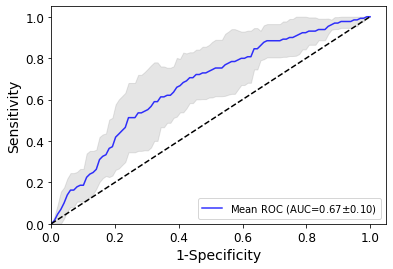

In [848]:
# ROC Curve
plot_ROC(SGD_pipeline,training_final, training_labels)

In [849]:
# Creating dictionary of parameters for randomized search
from scipy import stats
SGD_params = dict(SGD__loss = ['log'],
              SGD__penalty = ['l1','l2','elasticnet'],
              SGD__alpha = [0.0001,0.001,0.01,0.1,1,10,100],
              SGD__l1_ratio = np.linspace(0.01,0.99,99),
              SGD__class_weight = ['balanced'])

In [850]:
# RandomizedSearch
# Returns the SGD pipeline that maximizes AUC
from sklearn.model_selection import GridSearchCV
sgd_random = GridSearchCV(estimator = SGD_pipeline, param_grid = SGD_params,
                               cv = cv, verbose=10, n_jobs = -1, scoring = score, refit = 'AUC')
sgd_random.fit(training_final, training_labels)

Fitting 5 folds for each of 2079 candidates, totalling 10395 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('final_pipeline',
                                        Pipeline(steps=[('imputer',
                                                         IterativeImputer(max_iter=500)),
                                                        ('df_converter',
                                                         FunctionTransformer(func=<function Imputer_to_df at 0x7f779d1c6280>)),
                                                        ('transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('std_scaler',
                                                                                                           Standar...
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0

In [851]:
final_sgd = sgd_random.best_estimator_
sgd_random.best_params_
sgd_random.best_score_

{'SGD__alpha': 0.01,
 'SGD__class_weight': 'balanced',
 'SGD__l1_ratio': 0.99,
 'SGD__loss': 'log',
 'SGD__penalty': 'elasticnet'}

0.7447770487939027

In [852]:
training_labels_predict_f = cross_val_predict(final_sgd,
                                           training_final,
                                           training_labels, cv=cv)

training_labels_scores_f = cross_validate(final_sgd,
                                           training_final,
                                           training_labels, cv=cv, scoring=score)
                                  
# Confusion Matrix
confusion_matrix(training_labels, training_labels_predict_f)

array([[340, 101],
       [ 48,  81]])

In [853]:
# Precision Score
np.mean(training_labels_scores_f['test_Precision'])

# Recall Score
np.mean(training_labels_scores_f['test_Recall'])

# F1 Score
np.mean(training_labels_scores_f['test_F1 Score'])

# AUC Score
np.mean(training_labels_scores_f['test_AUC'])

0.4448338550777575

0.6289230769230769

0.5205240350358391

0.7447770487939027

In [854]:
num_list = num.columns
np.sum(final_sgd[1].coef_[0] != 0)

21

## Random Forest

In [670]:
# Random Forest Pipeline
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier()

RF_transformer = ColumnTransformer([
        ("cat", cat_pipeline, cat_attribs),
        ("num", 'passthrough' , num_attribs),
    ])

RF_pipeline = Pipeline([('RF_transformer', RF_transformer),('RF',RF_clf)])

In [671]:
# Training the model
RF_pipeline.fit(training_final,training_labels)

Pipeline(steps=[('RF_transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['excl_myect', 'Myectomy',
                                                   'ASA', 'GENDER', 'ANGINA',
                                                   'DYSPNEAatexertion',
                                                   'DIZZINESS', 'PRESYNCOPE',
                                                   'SYNCOPE', 'H_DM', 'HCMtype',
                                                   'Race', 'NYHA', 'Smoking',
                                                   'H_HTN', 'H_DL', 'Statin',
                                                   'H_stroke', 'H_CAD', 'H_MI',
                                                   'Antiplt'...
                              

In [676]:
# Predictions
RF_predict = RF_pipeline.predict(training_final)

In [677]:
# Confusion Matrix
confusion_matrix(training_labels, RF_predict)

array([[441,   0],
       [  0, 129]])

In [679]:
# Cross Validation
from sklearn.model_selection import cross_validate
cv = StratifiedKFold(random_state=42, shuffle=True)

score = {'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 


RF_predict_labels = cross_val_predict(RF_pipeline, training_final, training_labels, 
                        cv=cv, n_jobs=-1)

RF_cv_scores = cross_validate(RF_pipeline,training_final,training_labels, cv=cv, scoring=score)

# Confusion Matrix
confusion_matrix(training_labels,RF_predict_labels)

array([[433,   8],
       [117,  12]])

## XGB Classifier

In [97]:
# XGB Pipeline
# Does not impute missing data bc it takes care of them

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

num_attribs = list(num)
cat_attribs = list(cat)

xgb_clf = XGBClassifier(booster = 'gbtree',random_state = 42, eval_metric = 'logloss', use_label_encoder=False)
xgb_num_pipeline = Pipeline([('mmscaler', MinMaxScaler())])

xgb_transformer = ColumnTransformer([
        ("cat", cat_pipeline, cat_attribs),
        ("num", xgb_num_pipeline , num_attribs),
    ])

In [98]:
xgb_pipeline = Pipeline([('xgbtransform', xgb_transformer),('XGB',xgb_clf)])

In [99]:
# Training and Label Vectors
xgb_train = training
xgb_labels = training_labels

In [100]:
# Training the model
xgb_pipeline.fit(xgb_train,xgb_labels)

Pipeline(steps=[('xgbtransform',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['excl_myect', 'Myectomy',
                                                   'ASA', 'GENDER', 'ANGINA',
                                                   'DYSPNEAatexertion',
                                                   'DIZZINESS', 'PRESYNCOPE',
                                                   'SYNCOPE', 'H_DM', 'HCMtype',
                                                   'Race', 'NYHA', 'Smoking',
                                                   'Metformin', 'Insulin',
                                                   'H_HTN', 'H_DL', 'Statin',
                                                   'H_stroke', 'H_C...
                              

In [673]:
# Predictions
RF_predict = xgb_pipeline.predict(xgb_train)

In [102]:
# Confusion Matrix
confusion_matrix(xgb_labels, xgb_predict)

array([[413,   0],
       [  0, 121]])

In [103]:
# Precision Score 
precision_score(xgb_labels,xgb_predict)

# Recall Score
recall_score(xgb_labels,xgb_predict)

# F1 Score
f1_score(xgb_labels,xgb_predict)

1.0

1.0

1.0

In [104]:
# Cross Validation
from sklearn.model_selection import cross_validate
cv = StratifiedKFold(random_state=42, shuffle=True)

score = {'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 


xgb_predict_labels = cross_val_predict(xgb_pipeline, xgb_train, xgb_labels, 
                        cv=cv, n_jobs=-1)

xgb_cv_scores = cross_validate(xgb_pipeline,xgb_train,xgb_labels, cv=cv, scoring=score)

# Confusion Matrix
confusion_matrix(training_labels,xgb_predict_labels)

array([[386,  27],
       [ 93,  28]])

In [105]:
# ROC/AUC
np.mean(xgb_cv_scores['test_AUC'])

0.7225024488196689

In [106]:
# Hyperparameter Tuning
print('Parameters currently in use:\n')
print(xgb_pipeline[1].get_params())

Parameters currently in use:

{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 16, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'logloss'}


In [107]:
# Scoring and dictionary for randomized search
from scipy import stats

scoring = {'Balanced Accuracy': 'balanced_accuracy',
          'Accuracy': 'accuracy',
          'F1 Score':'f1',
          'AUC':'roc_auc',
          'Precision':'precision',
          'Recall':'recall'} 

objective = ['binary:logistic']
weights = [int(x) for x in np.linspace(1,20, num=20)]
n_estimators = stats.randint(150, 1000)
learning_rate = stats.uniform(0.01, 0.99)
max_depth = [int(x) for x in np.linspace(3, 20, num = 18)]
min_child_weight = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
gamma = stats.uniform(0.01,100)
reg_lambda = stats.uniform(0.001,10)
reg_alpha = stats.uniform(0.001, 10)
subsample = stats.uniform(0.001,1)

xgb_params = dict(XGB__objective = objective,
                 XGB__scale_pos_weight = weights,
                 XGB__n_estimators = n_estimators,
                 XGB__learning_rate = learning_rate,
                 XGB__max_depth = max_depth,
                 XGB__min_child_weight = min_child_weight,
                 XGB__gamma = gamma,
                 XGB__reg_lambda = reg_lambda,
                 XGB__reg_alpha = reg_alpha,
                 XGB__subsample = subsample)

In [108]:
# Randomized Search: Refit to the best F1
xgb_random_F1 = RandomizedSearchCV(estimator = xgb_pipeline, param_distributions = xgb_params, n_iter = 100, 
                               cv = cv, verbose=10, random_state=42, n_jobs = -1, scoring = scoring, refit = 'F1 Score',return_train_score=True)
xgb_random_F1.fit(xgb_train, xgb_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('xgbtransform',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('cat_encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['excl_myect',
                                                                                'Myectomy',
                                                                                'ASA',
                                                                                'GENDER',
                                                                                'ANGINA',
                                                                   

In [109]:
# Best Parameters from Randomized Search for F1 refit
xgb_random_F1.best_params_
xgb_random_F1.best_score_
xgb_best = xgb_random_F1.best_estimator_

{'XGB__gamma': 63.362971076089465,
 'XGB__learning_rate': 0.5404169372340109,
 'XGB__max_depth': 18,
 'XGB__min_child_weight': 1,
 'XGB__n_estimators': 350,
 'XGB__objective': 'binary:logistic',
 'XGB__reg_alpha': 3.2088006497173582,
 'XGB__reg_lambda': 1.8661851039985422,
 'XGB__scale_pos_weight': 3,
 'XGB__subsample': 0.5918929431882418}

0.5335891749982477

In [110]:
# Precision Score
xgb_random_F1.cv_results_['mean_test_Precision'][xgb_random_F1.best_index_]

# Recall Score
xgb_random_F1.cv_results_['mean_test_Recall'][xgb_random_F1.best_index_]

# F1 Score
xgb_random_F1.cv_results_['mean_test_F1 Score'][xgb_random_F1.best_index_]

# AUC Score
xgb_random_F1.cv_results_['mean_test_AUC'][xgb_random_F1.best_index_]

0.5149943778110945

0.5616666666666666

0.5335891749982477

0.7021527573709473

In [111]:
# Confusion Matrix
best_xgbF1_predict = cross_val_predict(xgb_best, xgb_train, xgb_labels, 
                        cv=cv, n_jobs=-1)

confusion_matrix(xgb_labels, best_xgbF1_predict)

array([[348,  65],
       [ 53,  68]])

<AxesSubplot:>

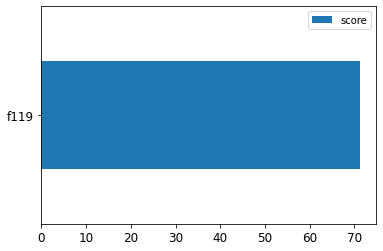

In [112]:
# Feature Importances
feature_important = xgb_best[1].get_booster().get_score(importance_type = 'gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')

In [114]:
xgb_train.columns[19]

'H_stroke'

## Evaluating on test set

In [115]:
test = test_set.copy()

In [116]:
# Creating copies of the features and labels
# Features ONLY
X_test = test_set.drop("Adverse_Outcome", axis=1)
# Labels ONLY
Y_test = test_set["Adverse_Outcome"].copy()
Y_test.value_counts()

0    139
1     40
Name: Adverse_Outcome, dtype: int64

In [117]:
# Predictions
xgb_final_pred = xgb_best.predict(X_test)

In [118]:
# Confusion Matrix
confusion_matrix(Y_test,xgb_final_pred)

array([[113,  26],
       [ 19,  21]])

In [119]:
xgbF1_final_prob = xgb_best.predict_proba(X_test)

In [120]:
# ROC Curve 
# Function to plot ROC_Curves
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    [...] # Add axis labels and grid

0.668974820143885

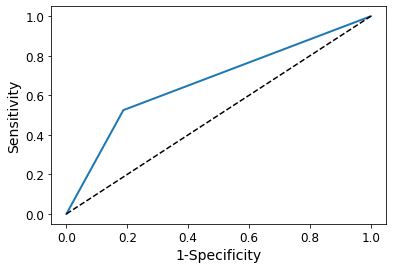

In [121]:
# ROC Curve
xgbF1_test_fpr, xgbF1_test_tpr, xgbF1_test_thresholds = roc_curve(Y_test, xgbF1_final_prob[:,1])
plot_roc_curve(xgbF1_test_fpr, xgbF1_test_tpr)
roc_auc_score(Y_test, xgbF1_final_prob[:,1])